# Didn't finish this notebook training, only tested for bugs.

# Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
import importlib
import helper.series

In [4]:
importlib.reload(helper.series)

<module 'helper.series' from '/home/jupyter/multitarget_training/helper/series.py'>

In [5]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
matplotlib 3.0.3
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [6]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Dataset Builder

In [7]:
def timeseries_dataset(series, window_size, shift, batchsize, targetsize):
    """
    From the original timeseries it generates the inputs for the network, and the labels.
    The labels lenght will be the target lenght of the forecast.
    Parameters:
      series: the input time series
      window_size: the lenght of the input
      shift: window shift along the series
      batchsize: batchsize
      targetsize: the size of the forecasted length
    Output: dataset of the input and label batches
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    stype = ds.element_spec.dtype
    ds = ds.window(window_size + targetsize, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + targetsize))
    if targetsize > 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], tf.map_fn(lambda i: window[i+1:i+1+targetsize], tf.range(window_size), dtype=stype)))
    elif targetsize == 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], window[targetsize:, np.newaxis]))
    elif targetsize == 0:
        ds = ds.map(lambda window: (window[:, np.newaxis], window[:, np.newaxis]))          
    return ds.batch(batchsize, drop_remainder=True)

# Build Time Series

In [8]:
time = np.arange(8 * 365)
builder = helper.series.SeriesBuilder(baseline=10, slope=0.05, period=365, amplitude=50, noise_level=2)
t_series = builder.generate_series(time)

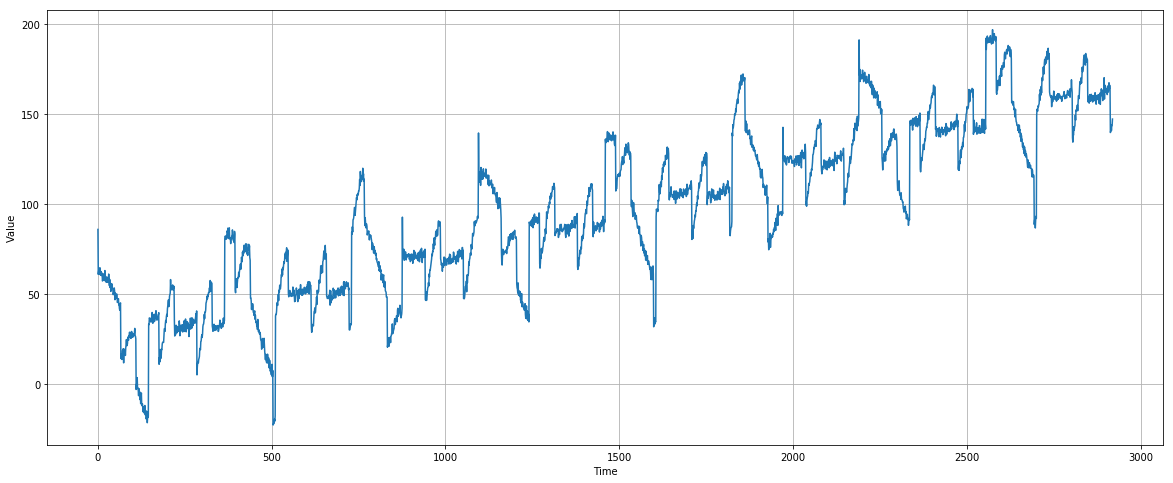

In [9]:
plt.figure(figsize=(20,8))
helper.series.plot_series(time, t_series)

In [10]:
# check output of the function
ds_demo = timeseries_dataset(time, window_size=3, shift=1, batchsize=2, targetsize=2)
next(iter(ds_demo))

(<tf.Tensor: shape=(2, 3, 1), dtype=int64, numpy=
 array([[[0],
         [1],
         [2]],
 
        [[1],
         [2],
         [3]]])>, <tf.Tensor: shape=(2, 3, 2), dtype=int64, numpy=
 array([[[1, 2],
         [2, 3],
         [3, 4]],
 
        [[2, 3],
         [3, 4],
         [4, 5]]])>)

In [11]:
# split the time and timeseries to train and validation set
time_train = time[:365*6]
x_train = t_series[:365*6]
time_valid = time[365*6:365*7]
x_valid = t_series[365*6:365*7]
time_test = time[365*7:]
x_test = t_series[365*7:]

In [22]:
# build the training / validation dataset for the 1 and more target size
train_set_1 = timeseries_dataset(x_train, window_size=30, shift=1, batchsize=16, targetsize=1)
valid_set_1 = timeseries_dataset(x_valid, window_size=30, shift=1, batchsize=16, targetsize=1)
test_set_1 = timeseries_dataset(x_test, window_size=30, shift=1, batchsize=16, targetsize=1)

train_set_10 = timeseries_dataset(x_train, window_size=30, shift=1, batchsize=16, targetsize=10)
valid_set_10 = timeseries_dataset(x_valid, window_size=30, shift=1, batchsize=16, targetsize=10)
test_set_10 = timeseries_dataset(x_test, window_size=30, shift=1, batchsize=16, targetsize=10)

# Network Layouts and Trainers

In [23]:
def simple_lstm_layout(batchsize, targetsize):  
    """
    Define a simple LSTM layout
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # model layout
    model = keras.models.Sequential([
    keras.layers.LSTM(20, 
                      return_sequences=True,
                      batch_input_shape=[batchsize, None, 1]),
    keras.layers.LSTM(20, 
                      return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(targetsize)),
    keras.layers.Lambda(lambda x: x * 200.0) # scale the outputs for faster learning
    ])
    return model

In [24]:
def learning_rate_finder(model, train_set):  
    """
    Goes trough learning rates and gives back the history object
    to find optimal learning rate.
    """
    # check learning rates to find the best
    lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    # get history to find the best learning rate
    return model.fit(train_set, epochs=2, callbacks=[lr_schedule]) # epochs: 100

In [26]:
def model_trainer(model, lr, train_set, valid_set, checkpoint_name):
    """
    Builds simple lstm network.
    Returns the history object
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9) # use best learning rate estimation
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    model_checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_name, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=50)
    return model.fit(train_set, epochs=5, # epochs 5000
            validation_data=valid_set,
            callbacks=[early_stopping, model_checkpoint])

# Test LSTM with target size 1

In [27]:
model_lstm_ts1 = simple_lstm_layout(batchsize=16, targetsize=1)

Epoch 1/2
135/135 [==============================] - 18s 131ms/step - loss: 99.0284 - mae: 99.5283
Epoch 2/2
135/135 [==============================] - 12s 90ms/step - loss: 90.6921 - mae: 91.1921


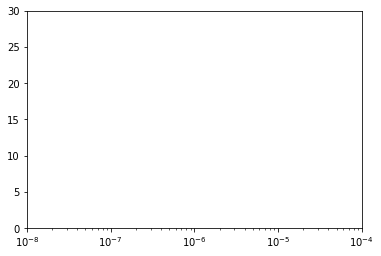

In [28]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts1, train_set=train_set_1), 1e-8, 1e-4, 0, 90)

In [29]:
# we see that lr around 2e-7 can be good, so train the network with that
model_lstm_ts1 = simple_lstm_layout(batchsize=16, targetsize=1)
history_lstm_1 = model_trainer(model_lstm_ts1, lr = 5e-6, train_set = train_set_1, valid_set = valid_set_1, checkpoint_name = "cp_lstm_1.h5")

Epoch 1/5
135/135 [==============================] - 13s 96ms/step - loss: 21.1725 - mae: 21.6661 - val_loss: 26.0865 - val_mae: 26.5839
Epoch 2/5
135/135 [==============================] - 6s 44ms/step - loss: 20.5445 - mae: 21.0392 - val_loss: 24.2263 - val_mae: 24.7232
Epoch 3/5
135/135 [==============================] - 7s 54ms/step - loss: 22.1770 - mae: 22.6716 - val_loss: 22.5413 - val_mae: 23.0375
Epoch 4/5
135/135 [==============================] - 7s 54ms/step - loss: 20.3564 - mae: 20.8462 - val_loss: 19.0717 - val_mae: 19.5688
Epoch 5/5
135/135 [==============================] - 7s 55ms/step - loss: 18.4592 - mae: 18.9520 - val_loss: 21.1321 - val_mae: 21.6284


In [34]:
model_lstm_ts1 = keras.models.load_model("cp_lstm_1.h5")

(320, 30, 1)
(320,)


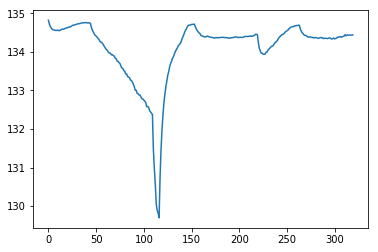

In [35]:
rnn_forecast = model_lstm_ts1.predict(test_set_1)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

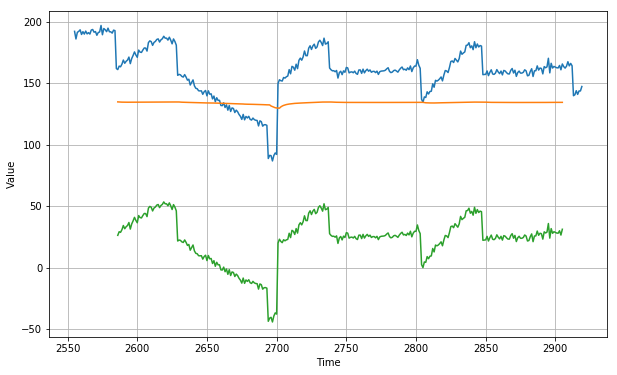

In [36]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[31:-14], rnn_forecast)
helper.series.plot_series(time_test[31:-14], x_test[31:-14] - rnn_forecast)

In [38]:
keras.metrics.mean_absolute_error(x_test[31:-14], rnn_forecast).numpy()

27.014578

# Test LSTM with target size 10

In [39]:
model_lstm_ts10 = simple_lstm_layout(batchsize=16, targetsize=10)

Epoch 1/2
134/134 [==============================] - 13s 98ms/step - loss: 60.4866 - mae: 60.9854
Epoch 2/2
134/134 [==============================] - 9s 65ms/step - loss: 59.7314 - mae: 60.2301


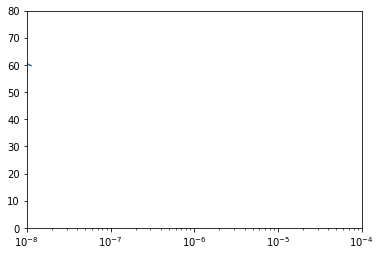

In [40]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts10, train_set=train_set_10), 1e-8, 1e-4, 0, 80)

In [42]:
# we see that lr around 2e-6 can be good, so train the network with that
model_lstm_ts10 = simple_lstm_layout(batchsize=16, targetsize=10)
history_lstm_10 = model_trainer(model_lstm_ts10, lr = 2e-6, train_set = train_set_10, valid_set = valid_set_10, checkpoint_name = "cp_lstm_10.h5")

Epoch 1/5
134/134 [==============================] - 15s 110ms/step - loss: 42.1723 - mae: 42.6698 - val_loss: 70.3096 - val_mae: 70.8092
Epoch 2/5
134/134 [==============================] - 9s 70ms/step - loss: 34.2788 - mae: 34.7756 - val_loss: 60.2074 - val_mae: 60.7066
Epoch 3/5
134/134 [==============================] - 9s 70ms/step - loss: 27.4128 - mae: 27.9082 - val_loss: 51.3595 - val_mae: 51.8583
Epoch 4/5
134/134 [==============================] - 9s 71ms/step - loss: 23.9617 - mae: 24.4559 - val_loss: 45.2944 - val_mae: 45.7931
Epoch 5/5
134/134 [==============================] - 10s 74ms/step - loss: 22.3753 - mae: 22.8692 - val_loss: 41.2398 - val_mae: 41.7385


In [43]:
model_lstm_ts10 = keras.models.load_model("cp_lstm_10.h5")

(320, 30, 10)
(320,)


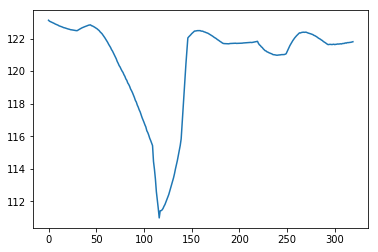

In [44]:
rnn_forecast = model_lstm_ts10.predict(test_set_10)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

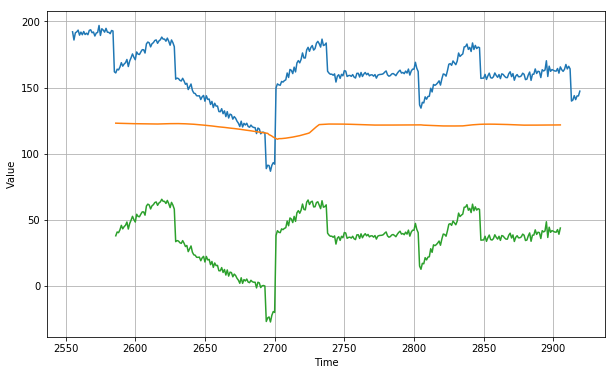

In [46]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[31:-14], rnn_forecast)
helper.series.plot_series(time_test[31:-14], x_test[31:-14] - rnn_forecast)

In [48]:
keras.metrics.mean_absolute_error(x_test[31:-14], rnn_forecast).numpy()

37.748478